In [166]:
import pandas as pd
from brian2 import *
import matplotlib.pyplot as plt

###  Model Equations

The Izhikevich spiking neuron model is defined by the following differential equations:

- **Membrane potential (`v`)**:
  \[
  \frac{dv}{dt} = 0.04v^2 + 5v + 140 - u + I
  \]

- **Recovery variable (`u`)**:
  \[
  \frac{du}{dt} = a(bv - u)
  \]

Where:

- `v` — membrane potential (in mV)  
- `u` — membrane recovery variable (models K⁺ activation and Na⁺ inactivation)  
- `I` — input current (external stimulation)  
- `a, b, c, d` — parameters defining the neuron's spiking dynamics

The neuron spikes when:
\[
v \geq 30 \, \text{mV}
\]
and is then reset:
\[
v \leftarrow c, \quad u \leftarrow u + d
\]


In [167]:
data = pd.read_csv("../data/spike_matrix.csv")

In [168]:
data

,Time,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch1,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch10,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch11,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch12,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch13,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch14,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch2,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch202,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch205,...,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch262,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch263,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch264,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch3,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch4,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch5,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch6,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch7,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch8,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch9
0,0.000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799996,1799.996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799997,1799.997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799998,1799.998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799999,1799.999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
start_scope()

In [176]:
timesteps = data.iloc[:, 0].values  # kolumna czasu jako NumPy array
spike_matrix = data.iloc[:, 1:].values  # dane binarne jako NumPy array

# Parametry
n_neurons = spike_matrix.shape[1]
duration = len(timesteps) * ms

In [177]:
# Model
eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I)/ms : 1
du/dt = a*(b*v - u)/ms : 1
I : 1  # external input
a : 1
b : 1
c : 1
d : 1
'''

# Neurony
G = NeuronGroup(n_neurons, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
G.v = -65

G.a = 0.02
G.b = 0.2
G.u = G.b * G.v
G.c = -50  # bardziej depolaryzowany reset
G.d = 2    # słabsza adaptacja


In [178]:
# Stymulacja: nadpisujemy I w każdej chwili
@network_operation(dt=1 * ms)
def update_input(t):
    idx = int(t / ms)
    if idx < len(spike_matrix):
        G.I = spike_matrix[idx] * 16.76  # skalowanie bodźca


WARNING    The object 'networkoperation' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/6y/g2p2w1qs6zs509fmkdpp5b4m0000gn/T/ipykernel_76761/1036813829.py', line 2, in <module>
    @network_operation(dt=1 * ms) [brian2.core.base.unused_brian_object]


In [179]:
spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record=True)

WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/6y/g2p2w1qs6zs509fmkdpp5b4m0000gn/T/ipykernel_76761/3540162736.py', line 13, in <module>
    G = NeuronGroup(n_neurons, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler') [brian2.core.base.unused_brian_object]


In [180]:
run(duration)

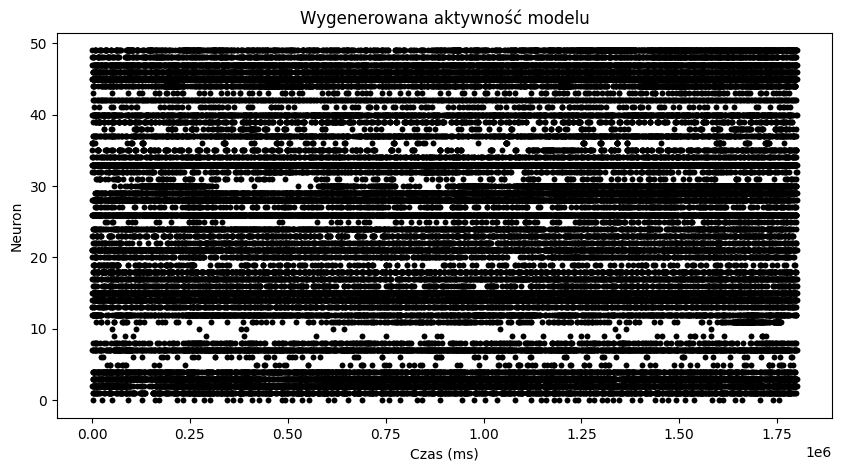

In [181]:
plt.figure(figsize=(10, 5))
plt.plot(spikemon.t/ms, spikemon.i, '.k')
plt.xlabel("Czas (ms)")
plt.ylabel("Neuron")
plt.title("Wygenerowana aktywność modelu")
plt.show()

In [182]:
# Dane MEA – sumujemy po czasie (oś 0)
spikes_mea_per_neuron = spike_matrix.sum(axis=0)

# Model – zliczamy spike’i z Brian2
spikes_model_per_neuron = np.array([len(spikemon.spike_trains()[i]) for i in range(n_neurons)])

In [183]:
spikes_mea_per_neuron

array([   74,  3187,  7227,  5577,  4114,   103,   102,  2063,   483,
          33,    11,  1408,  1718,  2474,  7870,  4814,  1302,  1935,
        3804,   659,  1026,  6031,   752,  2279,  1395,   229,  4657,
         548,  4247,  3554,  2174,   241,   584, 12633,  1321,  1811,
         337,  1307,   470,  1452,  1999,   480,  1937,   243,  1928,
        7151,  3099,  5198,  1626,  2100])

In [184]:
spikes_model_per_neuron

array([ 136, 2300, 4855, 6343, 2798,  190,  142, 3022,  767,   66,   22,
        732, 2345, 1502, 5511, 5304, 1108, 2205, 2622,  532, 1440, 3923,
       1304, 1573, 2060,  432, 4538,  751, 4410, 4444, 2917,  353, 1001,
       8004, 1509, 1126,  263, 2082,  481, 1208, 2808,  296, 1116,  288,
       2348, 7356, 3666, 4014, 1971, 2871])

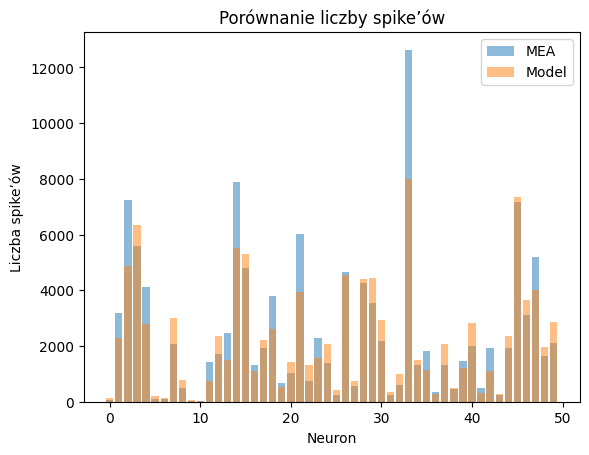

In [185]:
plt.bar(range(n_neurons), spikes_mea_per_neuron, alpha=0.5, label='MEA')
plt.bar(range(n_neurons), spikes_model_per_neuron, alpha=0.5, label='Model')
plt.xlabel('Neuron')
plt.ylabel('Liczba spike’ów')
plt.legend()
plt.title('Porównanie liczby spike’ów')
plt.show()


In [186]:
from scipy.stats import pearsonr

# MEA – neuron 0 (zakładamy 0/1 co 1 ms)
mea_0 = spike_matrix[:, 0]

# Model – neuron 0 → zamieniamy spike czasy na binarny wektor
sim_duration = len(spike_matrix)
sim_spikes = np.zeros(sim_duration)
model_spike_times = spikemon.spike_trains()[0]

for t in model_spike_times:
    idx = int(t/ms)
    if idx < sim_duration:
        sim_spikes[idx] = 1

# Korelacja
r, p = pearsonr(mea_0, sim_spikes)
print(f"Korelacja Pearsona (neuron 0): r = {r:.3f}, p = {p:.3g}")


Korelacja Pearsona (neuron 0): r = -0.000, p = 0.94


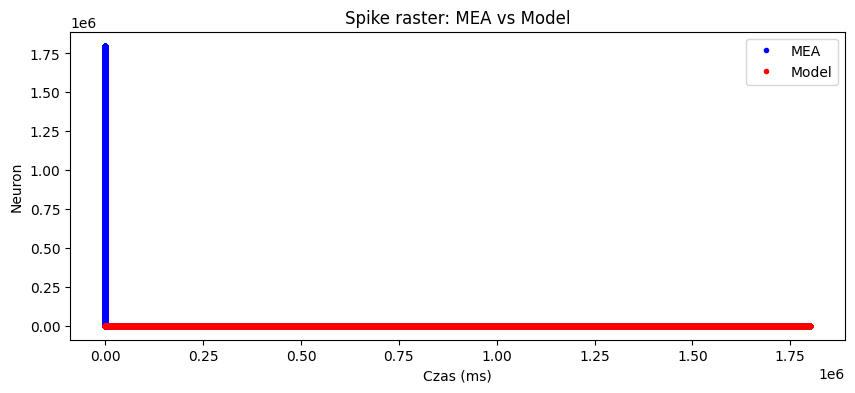

In [187]:
plt.figure(figsize=(10, 4))
mea_x, mea_y = np.where(spike_matrix.T)
plt.plot(timesteps[mea_x], mea_y, '.b', label="MEA")  # X: czas, Y: neuron
plt.plot(spikemon.t/ms, spikemon.i, '.r', label="Model")
plt.xlabel("Czas (ms)")
plt.ylabel("Neuron")
plt.title("Spike raster: MEA vs Model")
plt.legend()
plt.show()
